## Python ANOVA: 3 Ways to Carry out Two-Way ANOVA
This is the Jupyter Notebook for Two-Way ANOVA using Python. This Notebook contains the code for calculating the ANOVA table "by hand".Also, we can calculate it using "Pingouin" or "Statsmodels".

## 1. calculate by hands
Note, it also have the codes using seaborn to create an interaction plot instead of Statsmodels:

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress Warnings (not in the blog post)
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

In [4]:
data = 'Data_ToothGrowth.csv'

df = pd.read_csv(data, index_col=0)
df.head(20)

,len,supp,dose
1,4.2,VC,0.5
2,11.5,VC,0.5
3,7.3,VC,0.5
4,5.8,VC,0.5
5,6.4,VC,0.5
6,10.0,VC,0.5
7,11.2,VC,0.5
8,11.2,VC,0.5
9,5.2,VC,0.5
10,7.0,VC,0.5


#### Interaction plot using Seaborn

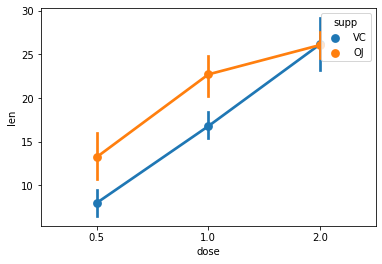

In [5]:
#暗示交互效应
ax = sns.pointplot(x='dose', y='len', hue='supp', data=df)

#### Calculating the Degrees of Freedom

In [6]:
N = len(df.len)
df_a = len(df.supp.unique()) - 1
df_b = len(df.dose.unique()) - 1
df_axb = df_a*df_b 
df_w = N - (len(df.supp.unique())*len(df.dose.unique()))

#### Calculating the Grand Mean

In [7]:
grand_mean = df['len'].mean()

#### Sum of Squares

In [8]:
# Sum of Squares A
ssq_a = sum([(df[df.supp == l].len.mean() - grand_mean)**2 for l in df.supp])
# Sum of Squares B
ssq_b = sum([(df[df.dose ==l].len.mean() - grand_mean)**2 for l in df.dose])
# Sum of Squares T
ssq_t = sum((df.len - grand_mean)**2)

#### Sum of Squares Within each factor 每个因素

In [9]:
vc = df[df.supp == 'VC']
oj = df[df.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) +sum((vc.len - vc_dose_means)**2)

#### Sum of Squares interaction 双因素相互作用
Since we have a two-way design we need to calculate the Sum of Squares for the interaction of A and B.

In [10]:
# Interaction
ssq_axb = ssq_t - ssq_a - ssq_b - ssq_w

#### Mean Square Errors

In [11]:
ms_a = ssq_a/df_a
ms_b = ssq_b/df_b
ms_axb = ssq_axb/df_axb
ms_w = ssq_w/df_w

#### Calculating F

The F-statistic is simply the mean square for each effect and the interaction divided by the mean square for within (error/residual).

In [12]:
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w

#### Obtaining the P-values
We can use the scipy.stats method f.sf to check if our obtained F-ratios is above the critical value. Doing that we need to use our F-value for each effect and interaction as well as the degrees of freedom for them, and the degree of freedom within.
我们可以使用scipy.stats 里的 f.sf 来检查我们获得的 F-值 是否高于临界值。要做到这一点，我们需要对每个效应和效应相互作用使用我们的F值，以及它们的自由度，以及组内自由度。

In [13]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

#### Creating the ANOVA Table

In [14]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}

columns=['sum_sq', 'df', 'F', 'PR(>F)']

aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

#### Effect Sizes
Here we get the eta squared and omega squared effect sizes and add it to the anova table and print the results:

In [15]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table1)
omega_squared(aov_table1)
print(aov_table1)

                sum_sq  df          F    PR(>F)    eta_sq  omega_sq
supp        205.350000   1  15.571979  0.000231  0.059484  0.055452
dose       2426.434333   2  91.999965       0.0  0.702864  0.692579
supp:dose   108.319000   2   4.106991   0.02186  0.031377  0.023647
Residual    712.106000  54        NaN       NaN       NaN       NaN


## 2. Two Way ANOVA using Pingouin

In [16]:
import pandas as pd
import pingouin as pg

aov = pg.anova(dv='len', between=['supp', 'dose'], data=df,
             detailed=True)                #####方法一，用Pingouin实现

print(aov)

        Source           SS  DF           MS          F         p-unc  \
0         supp   205.350000   1   205.350000  15.571979  2.311828e-04   
1         dose  2426.434333   2  1213.217167  91.999965  4.046291e-18   
2  supp * dose   108.319000   2    54.159500   4.106991  2.186027e-02   
3     Residual   712.106000  54    13.187148        NaN           NaN   

        np2  
0  0.223825  
1  0.773109  
2  0.132028  
3       NaN  


 * 'F' : F-values; 
 * 'p-unc' : uncorrected p-values;------未修正的P值
 * 'np2' : Partial eta-square effect sizes------偏平方效应尺寸

## 3. Two Way ANOVA using Statsmodels

In [17]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

In [18]:
data = 'Data_ToothGrowth.csv'

df = pd.read_csv(data, index_col=0)

# ANOVA
formula = 'len~C(supp)+C(dose)+C(supp):C(dose)'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)     #方法二，用statsmodels实现

print(aov_table)

                      sum_sq    df          F        PR(>F)
C(supp)           205.350000   1.0  15.571979  2.311828e-04
C(dose)          2426.434333   2.0  91.999965  4.046291e-18
C(supp):C(dose)   108.319000   2.0   4.106991  2.186027e-02
Residual          712.106000  54.0        NaN           NaN


#### Plotting the Residuals:

What is neat with using statsmodels is that we can also do some diagnostics. It is, for instance, very easy to take our model fit (the linear model fitted with the OLS method) and get a Quantile-Quantile (QQplot):

### 使用statsmodels的好处在于，我们还可以进行一些结果诊断。例如，对我们的模型进行拟合（用OLS方法拟合的线性模型）并得到 QQplot：

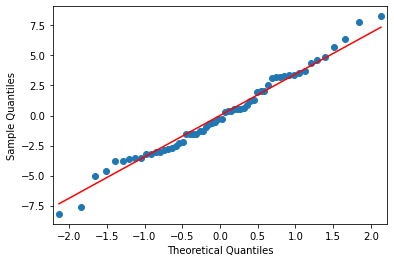

In [19]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

### Getting effect size

In [21]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

eta_squared(aov_table)
omega_squared(aov_table)

print(aov_table.round(4))

                    sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(supp)           205.3500   1.0  15.572  0.0002  0.0595    0.0555
C(dose)          2426.4343   2.0  92.000  0.0000  0.7029    0.6926
C(supp):C(dose)   108.3190   2.0   4.107  0.0219  0.0314    0.0236
Residual          712.1060  54.0     NaN     NaN     NaN       NaN
